In [46]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import matplotlib as mpl
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2022), "JJA", -80, 30, 20, 80, [200, 250, 300], None, None, None, reduce_da=True
)
da_s = exp_s.da
# exp_s_low = Experiment(
#     "ERA5", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
# )
# exp_T = Experiment(
#     "ERA5", "t", "6H", "all", "JJA", -60, 70, 25, 85, 250, 'hourofyear', {'hourofyear': ('win', 24 * 10)}, None,
# )
# da_T = exp_T.da


# Explicit SOM

In [13]:
da_s = da_s.sel(time=np.isin(da_s.time.dt.year, range(1979, 2000)))

In [3]:
def rescale(X):
    Xmin = X.min()
    Xmax = X.max()
    
    return (X - Xmin) / (Xmax - Xmin), Xmin, Xmax


def descale(X, Xmin, Xmax):
    return Xmin + (Xmax - Xmin) * X

norm_da = np.sqrt(degcos(da_s.lat))

X = (da_s * norm_da).values.reshape(da_s.shape[0], np.prod(da_s.shape[1:]))

In [4]:
@njit
def weighted_pairwise(X, Y=None, weight=None):
    X = X.astype(np.float32)
    if weight is None:
        weight = np.ones(X.shape[1], dtype=np.float32)
    else:
        weight = weight.astype(np.float32)
    twosides = True
    if Y is None:
        twosides = False
        Y = X
    else:
        Y = Y.astype(np.float32)
    output = np.zeros((len(X), len(Y)), dtype=np.float32)
    denominator = np.sum(weight)
    if twosides:
        for i, x in enumerate(X[:-1]):
            for j, y in enumerate(Y[(i + 1):]):
                dist = weight * (y - x) ** 2
                output[i, j] = np.sqrt(np.sum(dist)) / denominator
                output[j, i] = output[i, j]
        return output
    for i, x in enumerate(X):
        for j, y in enumerate(Y):
            dist = weight * (y - x) ** 2
            output[i, j] = np.sqrt(np.sum(dist)) / denominator
    return output

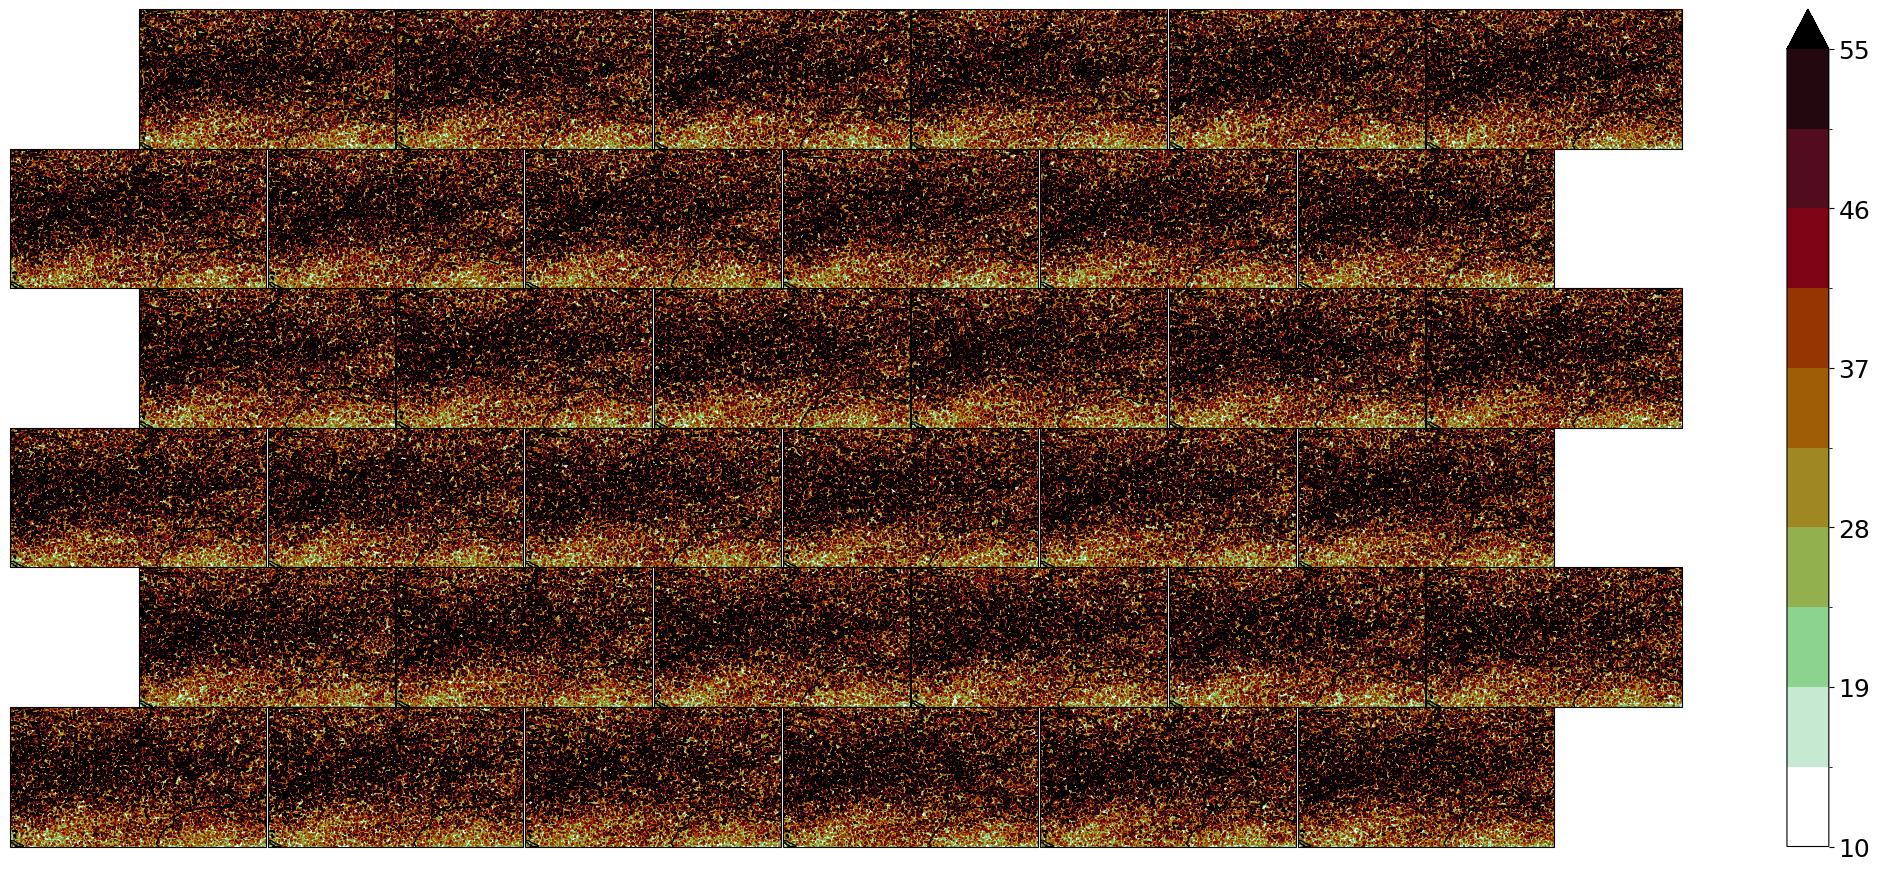

KeyboardInterrupt: 

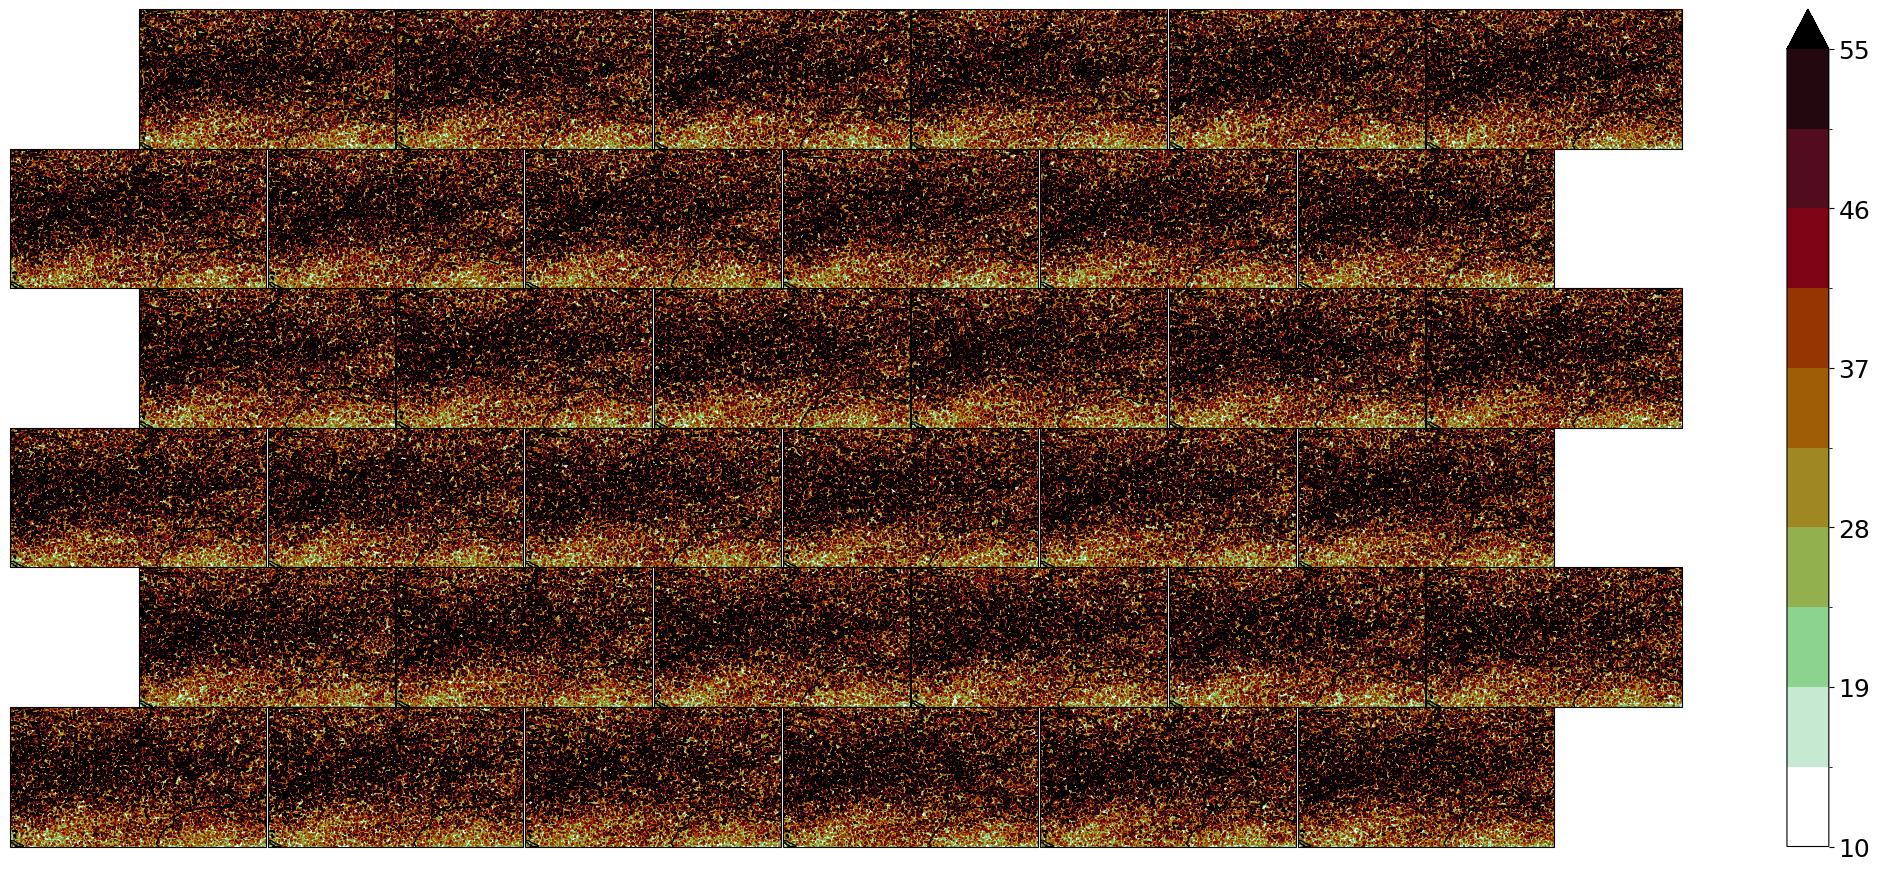

In [7]:
from IPython.display import display, clear_output
from simpsom.neighborhoods import Neighborhoods
%matplotlib inline


epochs = 10
start_sigma = 3
start_lr = 0.02
nbatch = 100
lon, lat = da_s.lon.values, da_s.lat.values
weight_coslat = degcos(lat[:, None] * np.arange(len(lon))[None, :]).ravel()
nei = Neighborhoods(np, 6, 6, "hexagons", PBC=True)
neighborhood_caller = partial(nei.neighborhood_caller, neigh_func="gaussian")
size = nei.width * nei.height
nodes = np.arange(size)
bounds = X_flat.min(axis=0), X_flat.max(axis=0)
weights = bounds[0][None, :] + (bounds[1][None, :] - bounds[0][None, :]) * np.random.rand(size, X_flat.shape[1])
# weights = np.random.rand(size, X_flat.shape[1])

def prepare_plot(weights, Xmin, Xmax, lon, lat):
    weights_to_plot = descale(weights, Xmin, Xmax).reshape(weights.shape[0], *da_s.shape[1:])
    weights_to_plot = xr.DataArray(weights_to_plot, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0)

weights_to_plot = prepare_plot(weights, Xmin, Xmax, lon, lat) 
clu = Clusterplot(nei.width, nei.height, exp_s.region, honeycomb=True)
kwargs, cbar_kwargs, im, _ = clu.setup_contourf(weights_to_plot, q=0.8, transparify=1, nlevels=11)
clu.fig.colorbar(
    im, ax=clu.axes, spacing="proportional", **cbar_kwargs
)
clear_output(wait = True)
for ax, wtp in zip(clu.axes, weights_to_plot):
    ax.cla()
    ax.coastlines()
    ax.contourf(lon, lat, wtp, **kwargs)
display(clu.fig)    

for epoch in range(epochs):
    sigma = start_sigma * np.exp(-epoch / epochs * 3)
    learning_rate = start_lr * np.exp(-epoch / epochs)
    thisX = X_flat.copy()
    np.random.shuffle(thisX)
    batches = np.array_split(thisX, nbatch)
    for i, batch in enumerate(batches):
        distances = weighted_pairwise(batch, weights, weight_coslat)
        indices = np.argmin(distances, axis=1)
        h = neighborhood_caller(nodes, sigma=sigma)
        series = indices[:, None] == nodes[None, :]
        pop = np.sum(series, axis=0)
        numerator = np.asarray([np.sum(batch[s, :], axis=0) for s in series.T])
        numerator = h @ numerator
        denominator = (h @ pop)[:, None]
        
        new_weights = np.where(denominator != 0, numerator / denominator, weights)
        weights = (1 - learning_rate) * weights + learning_rate * new_weights
        d = np.linalg.norm(batch[None, :, :] - weights[:, None, :], axis=-1)
        loss = np.mean(np.amin(h @ d, axis=0))
        print(f'loss: {loss:.2f}, batch: {i + 1}/{nbatch}, ite: {epoch + 1}/{epochs}, lr: {learning_rate:.2e}, sigma: {sigma:.2e}', end='\r')
    
    weights_to_plot = prepare_plot(weights, Xmin, Xmax, lon, lat) 
    clear_output(wait = True)
    for ax, wtp in zip(clu.axes, weights_to_plot):
        ax.cla()
        ax.coastlines()
        ax.contourf(lon, lat, wtp, **kwargs)
    display(clu.fig)    


In [ ]:
D_data = pairwise_distances(X, n_jobs=12)
D_data = D_data / D_data.max()
distances = pairwise_distances(X, weights)
bmus = np.argmin(distances, axis=1)
D_SOM = nei.distances[bmus, :][:, bmus]
D_SOM = D_SOM / D_SOM.max()

: 

In [5]:
pca = PCA(200)
X_pca = pca.fit_transform(X)
weights_expvar = pca.explained_variance_ratio_

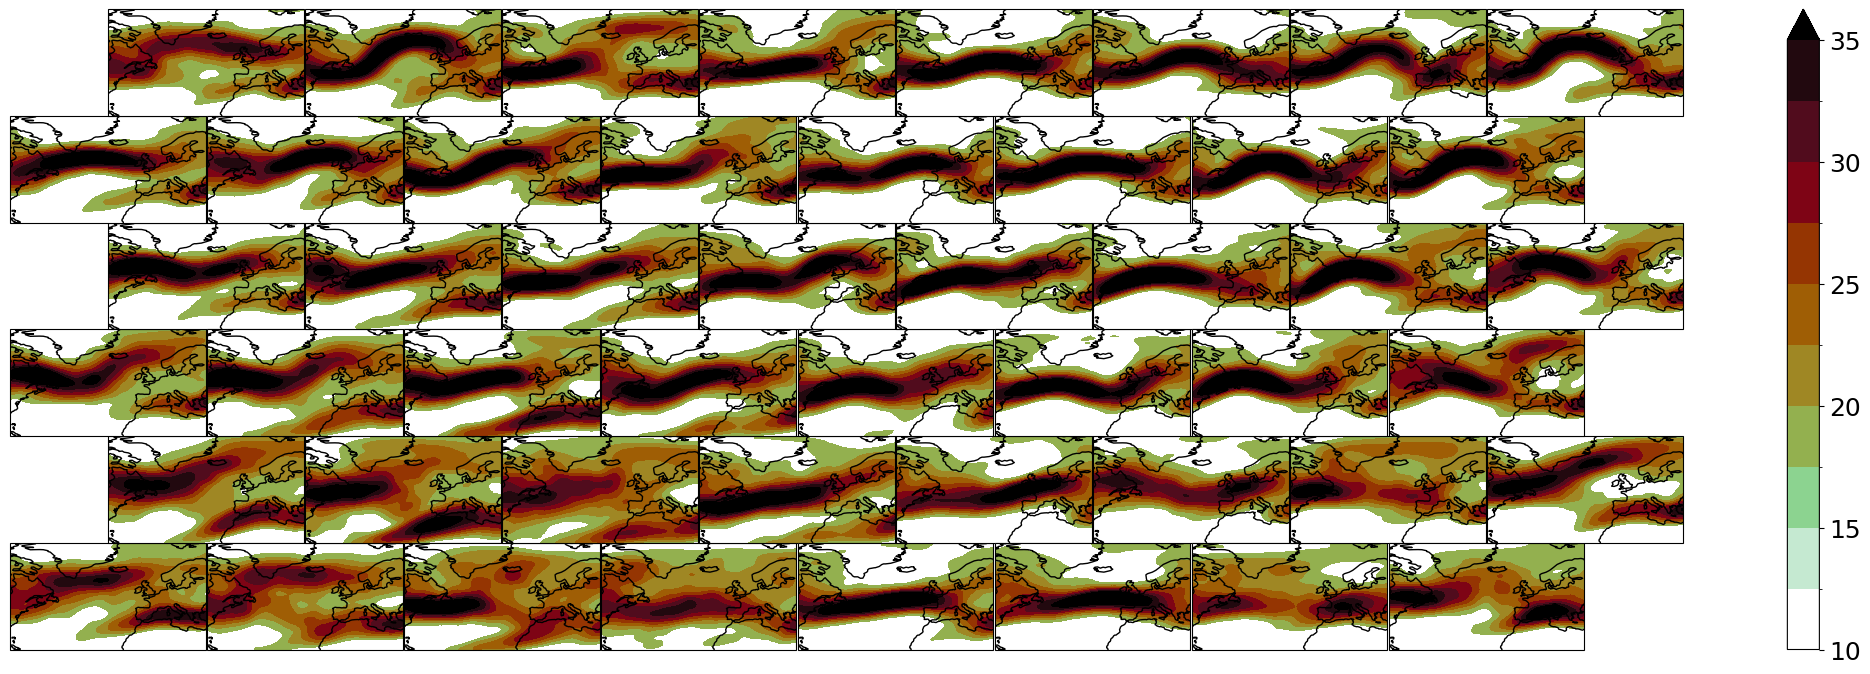

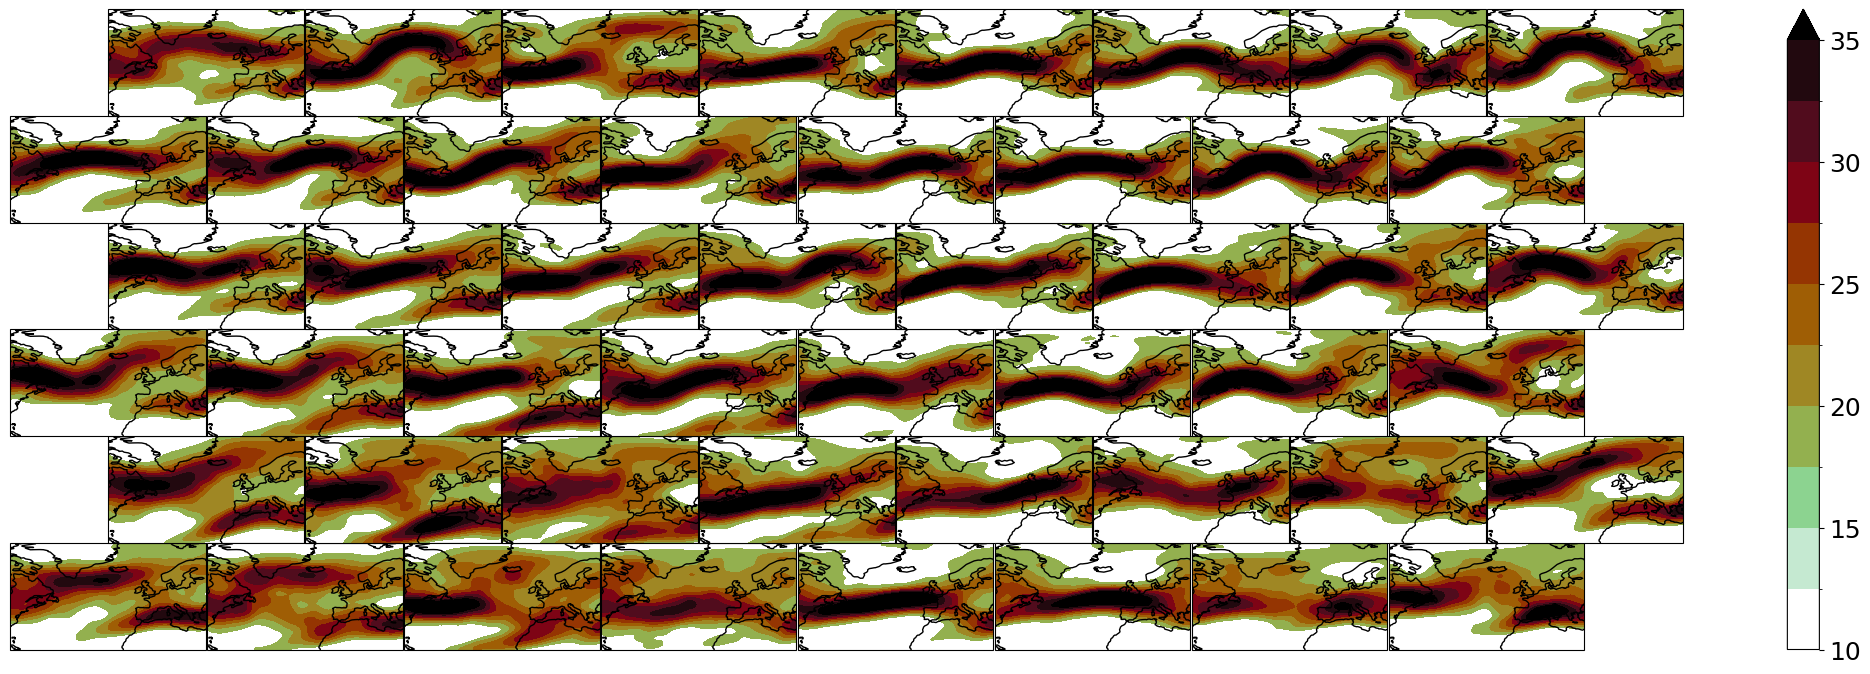

In [8]:
from IPython.display import display, clear_output
from simpsom.neighborhoods import Neighborhoods
%matplotlib inline

epochs = 100
start_sigma = 4
start_lr = 0.05
nbatch = len(X_pca) // 64
lon, lat = da_s.lon.values, da_s.lat.values
nei = Neighborhoods(np, 8, 6, "hexagons", PBC=True)
neighborhood_caller = partial(nei.neighborhood_caller, neigh_func="gaussian")
size = nei.width * nei.height
weights = np.random.rand(size, X_pca.shape[1])
nodes = np.arange(size)

def prepare_plot(weights, pca, lon, lat):
    weights_to_plot = pca.inverse_transform(weights).reshape(weights.shape[0], *da_s.shape[1:])
    weights_to_plot = xr.DataArray(weights_to_plot, coords={"cluster": nodes, "lat": lat, "lon": lon})
    return weights_to_plot.where(weights_to_plot > 0, 0) / norm_da

clu = Clusterplot(nei.height, nei.width, exp_s.region, honeycomb=True)
kwargs = None

for epoch in range(epochs):
    sigma = start_sigma * np.exp(-epoch / epochs * 3)
    learning_rate = start_lr * np.exp(-epoch / epochs)
    thisX = X_pca.copy()
    np.random.shuffle(thisX)
    batches = np.array_split(thisX, nbatch)
    for i, batch in enumerate(batches):
        # distances = weighted_pairwise(batch, weights, weights_expvar)
        distances = pairwise_distances(batch, weights)
        indices = np.argmin(distances, axis=1)
        h = neighborhood_caller(nodes, sigma=sigma)
        series = indices[:, None] == nodes[None, :]
        pop = np.sum(series, axis=0)
        numerator = np.asarray([np.sum(batch[s, :], axis=0) for s in series.T])
        numerator = h @ numerator
        denominator = (h @ pop)[:, None]
        
        new_weights = np.where(denominator != 0, numerator / denominator, weights)
        weights = (1 - learning_rate) * weights + learning_rate * new_weights
    d = pairwise_distances(thisX, weights)
    loss = np.mean(np.amin(h @ d.T, axis=0))
    print(f'loss: {loss:.2f}, batch: {i + 1}/{nbatch}, ite: {epoch + 1}/{epochs}, lr: {learning_rate:.2e}, sigma: {sigma:.2e}', end='\r')
    
    weights_to_plot = prepare_plot(weights, pca, lon, lat) 
    if kwargs is None:
        kwargs, cbar_kwargs, im, _ = clu.setup_contourf(weights_to_plot, q=0.97, transparify=3, nlevels=11)
        clu.fig.colorbar(
            im, ax=clu.axes, spacing="proportional", **cbar_kwargs
        )
    clear_output(wait = True)
    for ax, wtp in zip(clu.axes, weights_to_plot):
        ax.cla()
        ax.coastlines()
        ax.contourf(lon, lat, wtp, **kwargs)
    display(clu.fig)    


# Many SOMs

In [3]:
net, centers, labels = exp_s.som_cluster(
    8,
    6,
    200,
    return_type=RAW_REALSPACE,
    force=False,
    train_kwargs=dict(train_algo="batch", epochs=100, start_learning_rate=0.05),
)

populations = net.compute_populations()
coords = net.neighborhoods.coordinates
centers_all_jets = find_jets(xr.Dataset({"s": centers}))
centers_props = compute_all_jet_props(centers_all_jets, centers)
centers_props_ds_uncat = props_to_ds(centers_props, centers.cluster)
centers_props_ds = categorize_ds_jets(centers_props_ds_uncat)

100%|██████████| 48/48 [00:03<00:00, 12.70it/s]


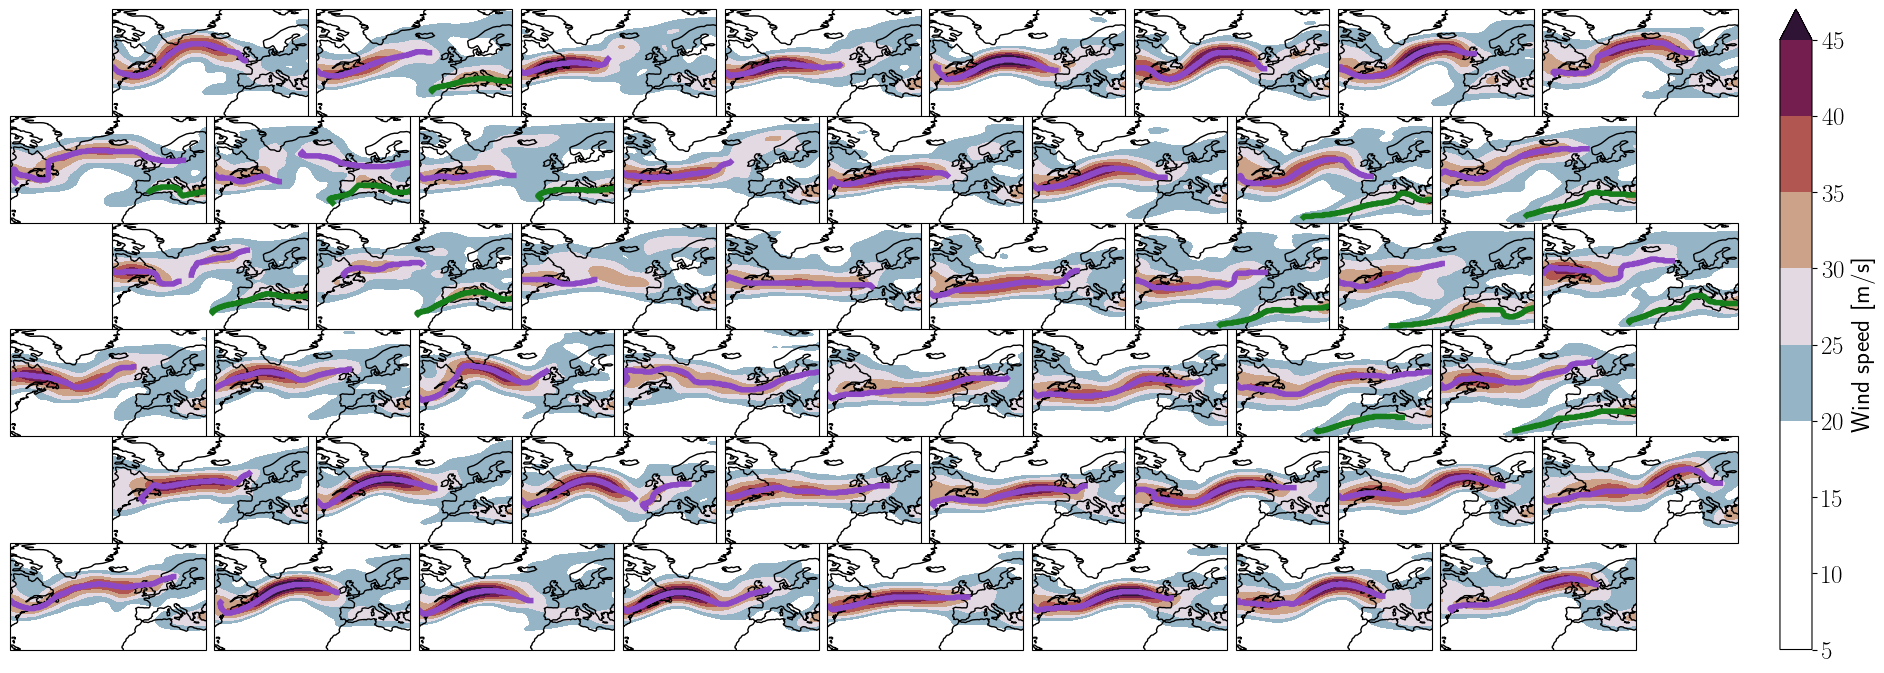

In [47]:
clu = Clusterplot(net.height, net.width, exp_s.region, honeycomb=True)
_ = clu.add_contourf(
    centers,
    cmap='twilight_shifted',
    transparify=3,
    nlevels=9,
    cbar_kwargs={"label": "Wind speed [m/s]", "pad": 0.02}
)
for jets, are_polar, ax in zip(centers_all_jets, centers_props_ds_uncat["is_polar"], clu.axes):
    for jet, is_polar in zip(jets, are_polar):
        color = COLORS5[int(is_polar)]
        ax.plot(*jet[["lon", "lat"]].to_numpy().T, lw=4, color=color)

## rt, multi

In [43]:
mask = labels_to_mask(labels)
mask_da = xr.DataArray(mask, coords={"time": labels.time.values, "cluster": np.arange(mask.shape[1])})

In [44]:
da = da_s
df = pd.read_csv(f"{DATADIR}/ERA5/daily_nao.csv", delimiter=",")
index = pd.to_datetime(df.iloc[:, :3])
series = xr.DataArray(df.iloc[:, 3].values, coords={"time": index})
nao_summer = series.interp_like(da_s)
nao_on_map = timeseries_on_map(nao_summer, net.bmus)[0]

yearly = mask_da.resample(time="1YE").sum().values
trends = np.zeros(net.n_nodes)
for k, yearly_ in enumerate(yearly.T):
    trends[k] = np.polyfit(
        np.arange(yearly.shape[0])[yearly_ != 0], yearly_[yearly_ != 0], deg=1
    )[0]


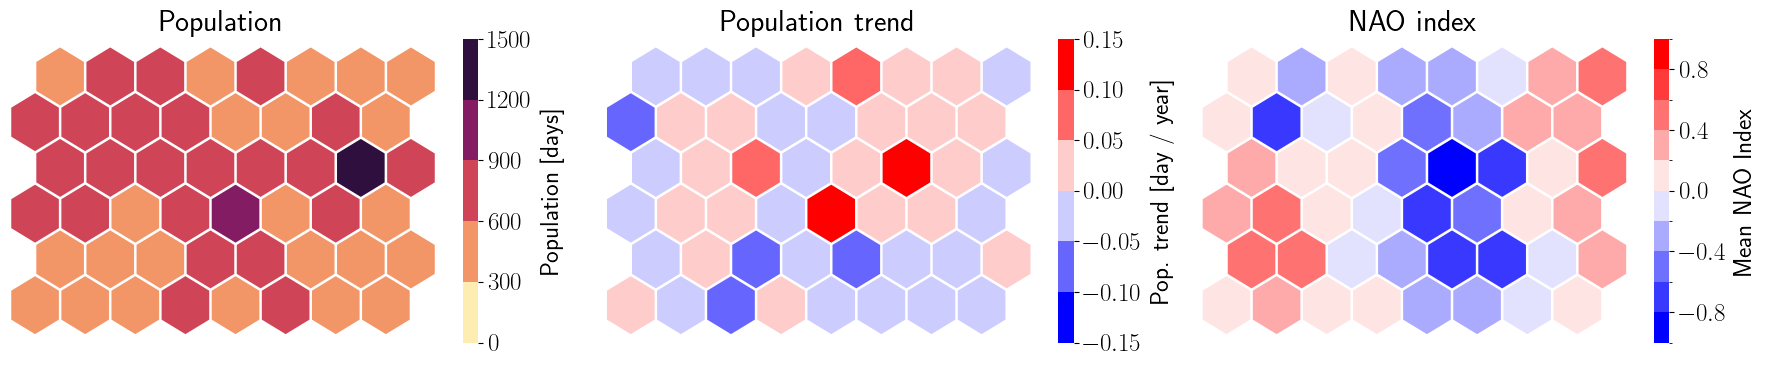

In [50]:
cmap = colormaps.matter
fig, axes = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    populations,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    cbar_label="Population [days]",
    fig=fig,
    ax=axes[0],
    fonzsize=mpl.rcParams["font.size"],
    discretify=1,
)
axes[0].set_title("Population")
fig, axes[1] = net.plot_on_map(
    trends,
    smooth_sigma=0,
    show=False,
    cmap="bwr",
    cbar_label="Pop. trend [day / year]",
    discretify=1,
    fig=fig,
    ax=axes[1],
    fonzsize=mpl.rcParams["font.size"],
)
axes[1].set_title("Population trend")
fig, axes[2] = net.plot_on_map(
    nao_on_map,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap="bwr",
    cbar_label="Mean NAO Index",
    discretify=1,
    fonzsize=mpl.rcParams["font.size"],
)
axes[2].set_title("NAO index")
fig.savefig(f'{FIGURES}/som_props/pop_trend_nao.png')

In [51]:
da_pvs = Experiment("ERA5", "surf", "pvs", "6H", (1959, 2022), "JJA", *exp_s.region, 250, "hourofyear", {"hourofyear": ("win", 40)}).da

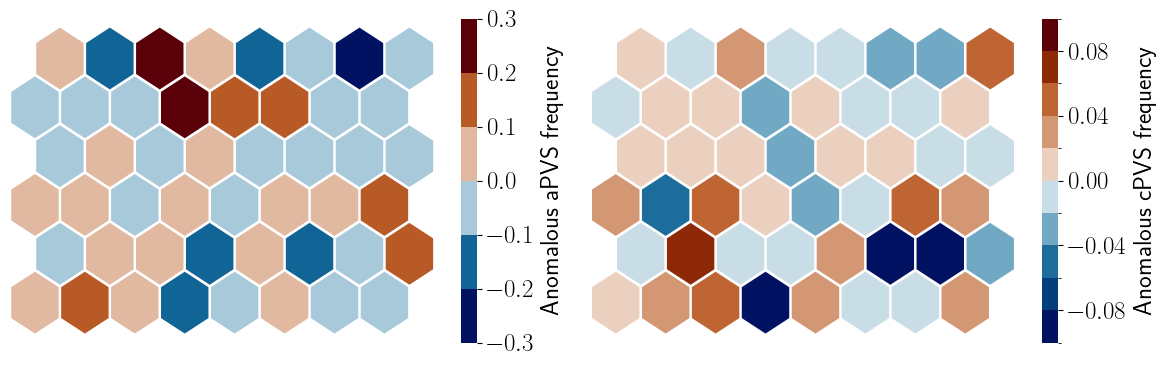

In [52]:
from matplotlib.colors import CenteredNorm
time_mask = np.isin(labels.time.values, da_pvs.time.values)
to_plot_anti = np.asarray([da_pvs.loc[:, 'anti'][mask_[time_mask]].mean().item() for mask_ in mask.T])
to_plot_cycl = np.asarray([da_pvs.loc[:, 'cycl'][mask_[time_mask]].mean().item() for mask_ in mask.T])

cmap = colormaps.vik
fig, axes = plt.subplots(1, 2, figsize=(12, 4), tight_layout=True)
fig, axes[0] = net.plot_on_map(
    to_plot_anti,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    fig=fig,
    ax=axes[0],
    cbar_label="Anomalous aPVS frequency",
    discretify=1,
)
fig, axes[1] = net.plot_on_map(
    to_plot_cycl,
    smooth_sigma=0,
    fig=fig,
    cmap=cmap,
    ax=axes[1],
    cbar_label="Anomalous cPVS frequency",
    discretify=1,
)
fig.savefig(f'{FIGURES}/som_props/PVS_activity.png')

In [53]:
yearbreak = np.sum(da_s.time.dt.year.values == 1999)
mean_res, max_res, trend_res = net.compute_residence_time(1, yearbreak=yearbreak)

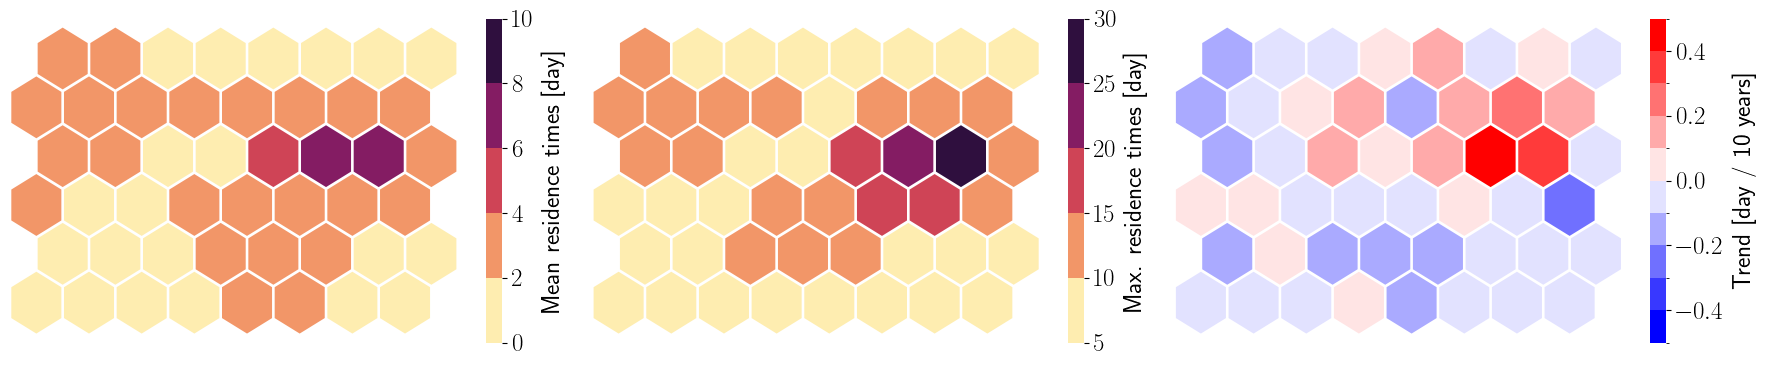

In [54]:
cmap = colormaps.matter
fig, axes = plt.subplots(1, 3, figsize=(18, 4), tight_layout=True)
axes = axes.ravel()
fig, axes[0] = net.plot_on_map(
    mean_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    cbar_label="Mean residence times [day]",
    fig=fig,
    ax=axes[0],
    fonzsize=mpl.rcParams["font.size"],
    discretify=1,
)
# axes[0].set_title("Mean residence times")
fig, axes[1] = net.plot_on_map(
    max_res / 4,
    smooth_sigma=0,
    show=False,
    cmap=cmap,
    cbar_label="Max. residence times [day]",
    fig=fig,
    ax=axes[1],
    fonzsize=mpl.rcParams["font.size"],
    discretify=1,
)
# axes[1].set_title("Population trend")
fig, axes[2] = net.plot_on_map(
    trend_res / 4 * 10,
    smooth_sigma=0,
    show=False,
    fig=fig,
    ax=axes[2],
    cmap="bwr",
    cbar_label="Trend [day / 10 years]",
    fonzsize=mpl.rcParams["font.size"],
    discretify=1,
)
# axes[2].set_title("NAO index")
fig.savefig(f'{FIGURES}/som_props/residence.png')

## jet indices

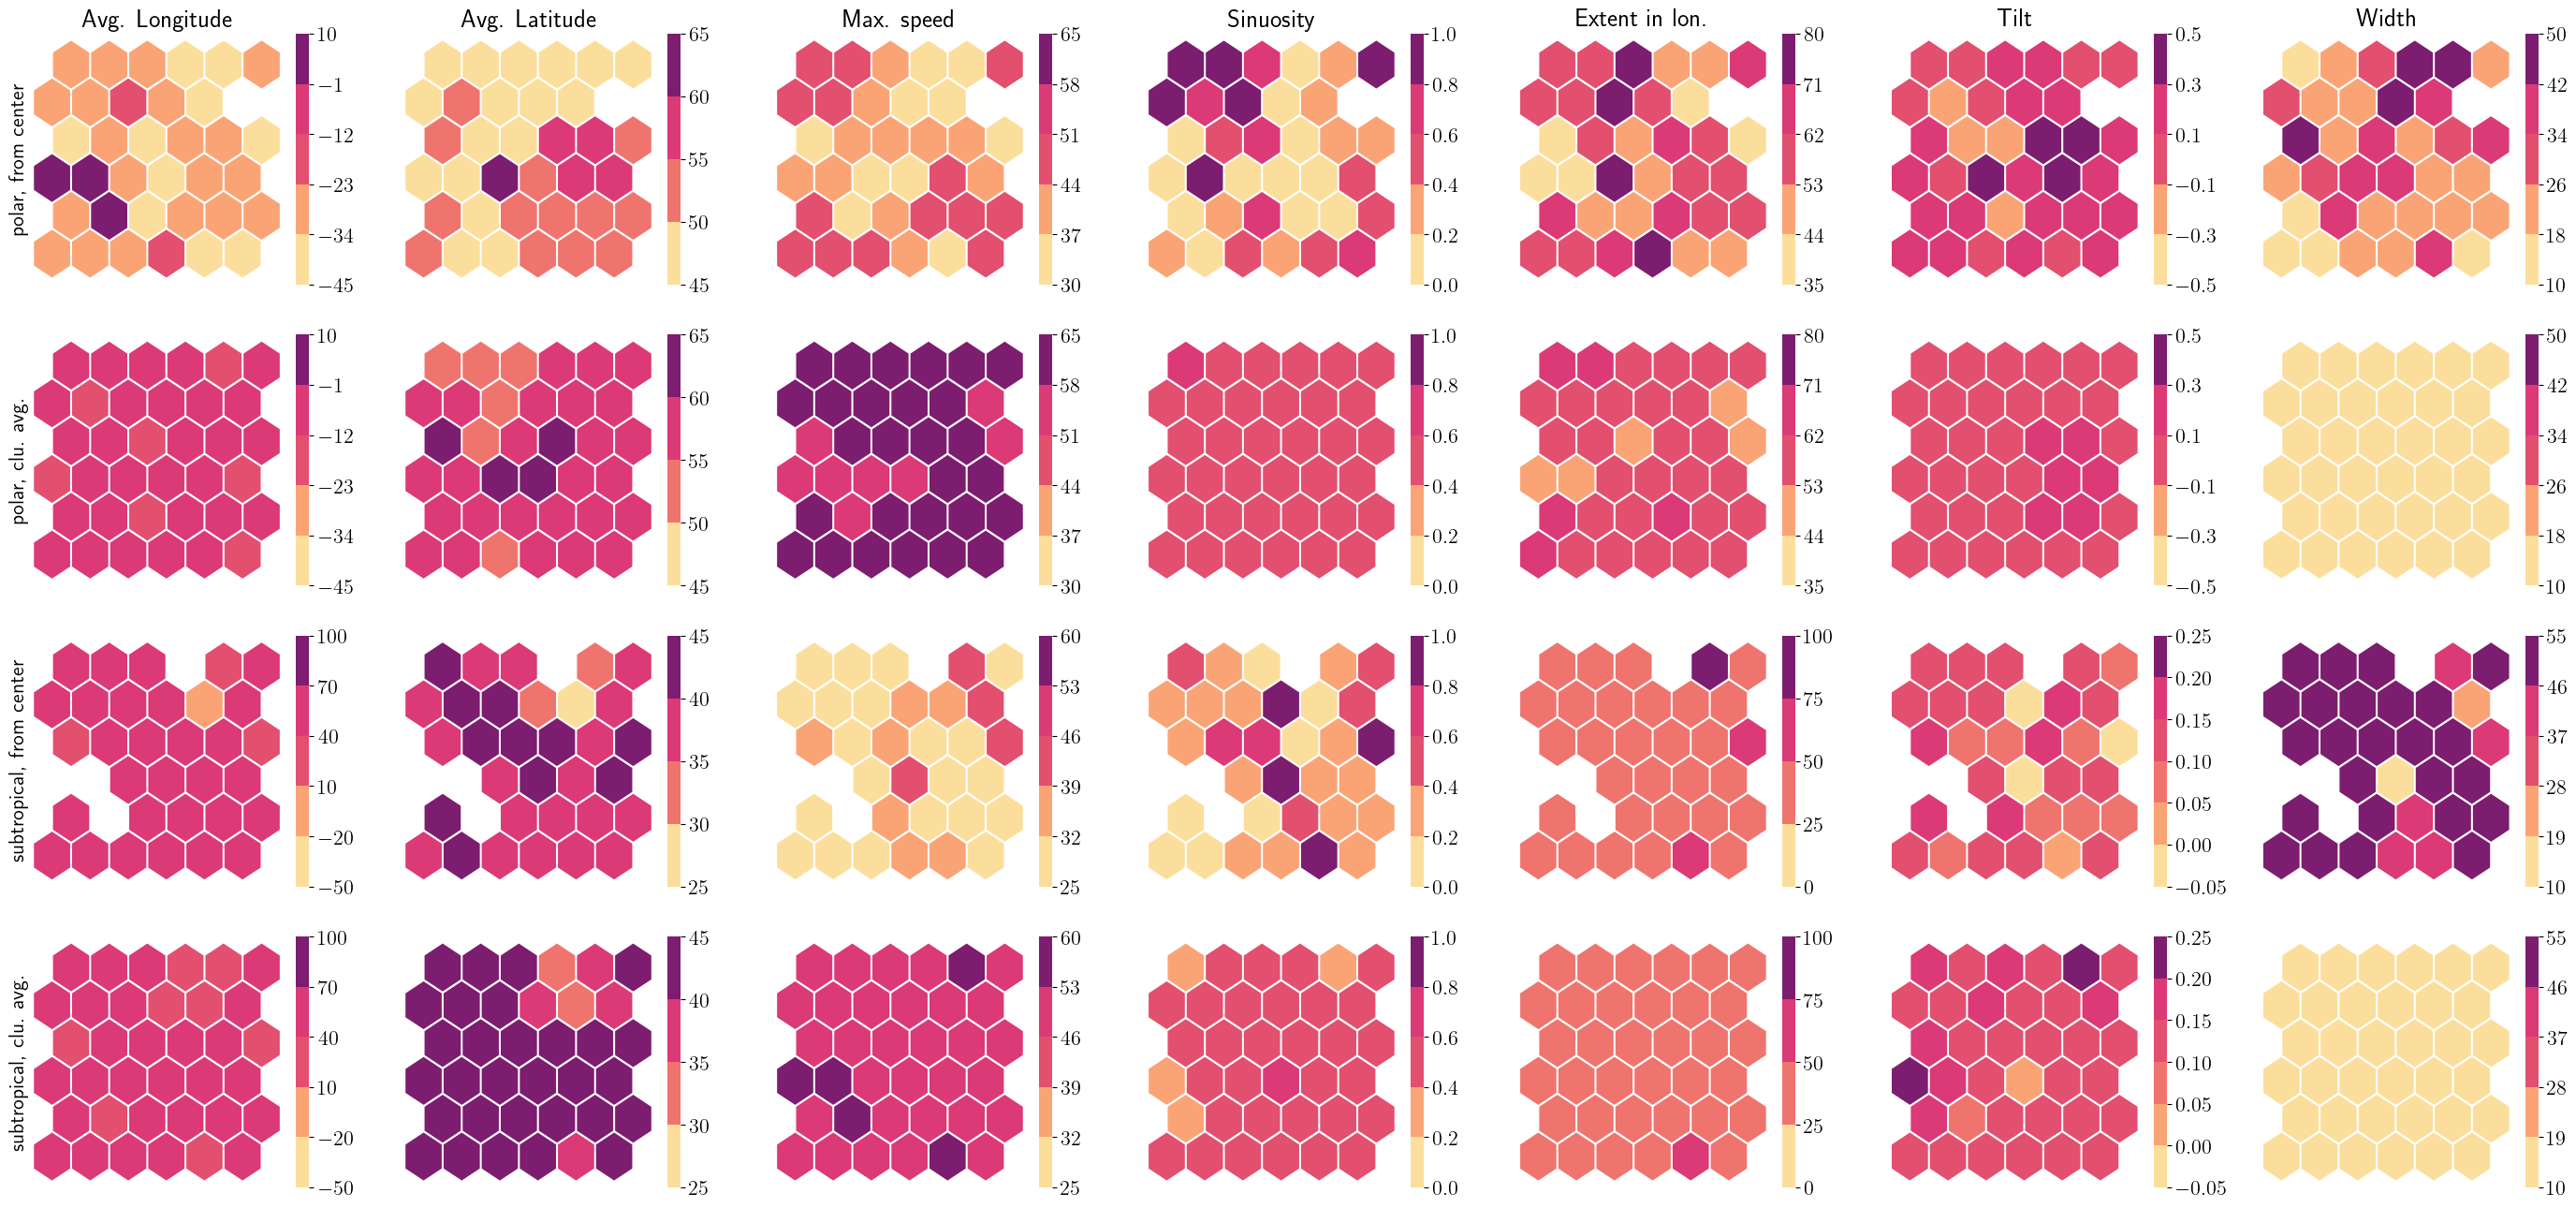

In [ ]:
# both at once : is the som jet-prop preserving ? Probably not heh
varnames_subset = ["mean_lon", "mean_lat", "Spe", "sinuosity", "lon_ext", "tilt", "width"]

centers_props_ds_catd = categorize_ds_jets(centers_props_ds)
kwargs = {"cmap": cmaps.sunsetdark}
fig, axes = plt.subplots(
    4, len(varnames_subset), figsize=(5 * len(varnames_subset), 16)
)
sub_title = ['from center', 'clu. avg.']
for k, varname in enumerate(varnames_subset):
    axes[0, k].set_title(PRETTIER_VARNAME[varname])
    for j, jet in enumerate(['polar', 'subtropical']):
        to_plot1 = np.asarray(
            [
                centers_props_ds_catd[varname].sel(jet=jet, cluster=k).mean().values
                for k in range(net.n_nodes)
            ]
        )
        to_plot2 = np.asarray(
            [props_as_ds[varname].sel(jet=jet)[mas].mean().values for mas in mask.T]
        )
        mini, maxi = np.nanmin([to_plot1, to_plot2]), np.nanmax([to_plot1, to_plot2])
        levels = create_levels([to_plot1, to_plot2], sym=False)[0]
        kwargs['norm'] = BoundaryNorm(levels, kwargs['cmap'].N)
        ax = axes[2 * j, k]
        fig, ax = net.plot_on_map(
            to_plot1,
            smooth_sigma=0,
            show=False,
            fig=fig,
            ax=ax,
            draw_cbar=True,
            **kwargs,
        )
        ax = axes[2 * j + 1, k]
        fig, ax = net.plot_on_map(
            to_plot2,
            smooth_sigma=0,
            show=False,
            fig=fig,
            ax=ax,
            draw_cbar=True,
            **kwargs,
        )
        if k == 0:
            for l, ax in enumerate(axes[2 * j : 2 * j + 2, k]):
                ax.axis("on")
                ax.spines[["right", "top", "left", "bottom"]].set_visible(False)
                ax.tick_params(
                    bottom=False, left=False, labelbottom=False, labelleft=False
                )
                ax.set_ylabel(f'{jet}, {sub_title[l]}')
fig.savefig(f'{FIGURES}/som_props/jet_indices.png')